# An introduction to Markov Chain Monte Carlo methods

In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In the CBC Parameter Estimation lecture we discussed the *posterior probability density*, a function that describes the probability density distribution of the system parameters given a detected gravitational wave signal. A typical black hole binary coalescence is described by 15 parameters within General Relativity: 2 black hole masses, 2 black hole spin magnitudes, 4 black hole spin directions, 2 angles desribing the orientation of the binary orbit, 2 angles describing the sky location of the system, the luminosity distance, and the phase and time of colescence.

In the PE [tutorial](https://git.ligo.org/jonah-kanner/odw-2018/blob/master/parameter_estimation/Calculating%20a%20Posterior%20Probability%20Density%20Function.ipynb) we discussed how the posterior density can be *maximized* in order to obtain the most probable parameters of the source. Here we discuss how to obtain error bars on these parameters.

Due to the high dimensionality of the posterior function (15D) grid or Monte Carlo methods are computationaly prohibitive. The LVC uses two main techniques to samples this multi-dimensional distribution: Markov Chain Monte Carlo (MCMC), and Nested Sampling. We will discuss the former; for more details see [here](https://arxiv.org/abs/1409.7215).

## Markov Chain Monte Carlo -- Metropolis Hastings

A *Markov Chain* is an ordered sequence of random samples from a predefined probability distribution where each sample depends only on the immediate previous sample. There are various algorithms that produce Markov Chains. We will use the Metropolis-Hastings algorithm.

Metropolis-Hastings algorithm: draw samples from a predifined probability density function $P(x)$

* Choose a "proposal density" $Q(y|x)$ to draw a new sample $y$ given a previous sample $x$.
* If $P(y) \geq P(x)$, keep the new sample
* If $P(y) < P(x)$, keep the new sample with probability $(P(y)/P(x))(Q(x|y)/Q(y|x))$
* If a sample is rejected, the old sample is repeated
* The normalization of $P$ doesn't matter. In the context of Bayes' theorem, this is the evidence

In [2]:
#Propose a new step (using a symmetric Gaussian proposal density centered at the old sample)
def ProposedStep(oldsamp,sigmaprop,D):
    newsamp = oldsamp + np.random.normal(0.,sigmaprop,D)
    return newsamp

#Hastings ratio
def HastingsRatio(newsamp,oldsamp,priorrange,PDF,*Pargs):
    if not ((np.array([p1 - p2 for p1, p2 in zip(newsamp, np.transpose(priorrange)[:][0])])>0).all() \
            and (np.array([p2 - p1 for p1, p2 in zip(newsamp,np.transpose(priorrange)[:][1])])>0).all()):
        acc = False
        return acc, oldsamp # make sure the samples are in the desired range
    newprob = PDF(newsamp,*Pargs)
    oldprob = PDF(oldsamp,*Pargs)
    if newprob >= oldprob:
        acc = True
        return acc, newsamp
    else:
        prob = newprob/oldprob
        acc = np.random.choice([True,False],p=[prob,1.-prob])
        return acc, acc*newsamp + (1. - acc)*oldsamp 

#Function that runs the chain
def MCMC(PDF,D,Nsteps,priorrange,sigmaprop,*Pargs):
    #Draw a random starting point
    oldsamp=np.array([np.random.uniform(priorrange[d][0],priorrange[d][1]) for d in range(D)])
    
    #Count the number of accepted samples
    count = 0 
    
    #Store all samples
    samples = [oldsamp]
    
    for i in range(Nsteps):
        newsamp = ProposedStep(oldsamp,sigmaprop,D) #Propose a new sample
        acc, newsamp = HastingsRatio(newsamp,oldsamp,priorrange,PDF,*Pargs) #decide whether or not to accept it
        samples.append(newsamp) #Add the sample to the list of samples
        if acc:
            count += 1
        oldsamp = newsamp #Move to the new sample
        
    #compute the acceptance ratio    
    AR = 1.*count/Nsteps 
    return np.array(samples), AR


## A simple signal

Even with MCMC methods, sampling from the full 15D posterior density function for the parameters of a black hole binary can be very computationaly intensive (days to weeks). So here we will discuss a simpler 3D problem with a simulated signal which is a sine wave of some amplitude, frequency, and initial phase.


Our data is

$$d = A\ cos(f t+\phi) + n,$$

where $A\ cos(f t+\phi)$ is our signal and $n$ is some observational error. 

We will assume that we have several measurements and that the errors are Gaussian (an assumption we also make about the noise of gravitational wave detectors) and independent (this is equivalent to the detector noise being stationary).

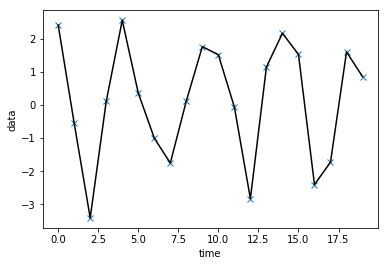

In [27]:
#Simulate a set of Nobs observations
Nobs = 20
sigma = 1 #the standard deviation of the Gaussian noise, equivalent to the PSD of the detector

#fix the true values of the parameters
A = 2. 
f = 4.*2.*np.pi/Nobs
phi = 1.

#Create a noise realizations
np.random.seed(10)
n = np.random.normal(0.,sigma,Nobs)

#Observation times
t = np.arange(Nobs)

#Generate the data
data = A*np.cos(f*t+phi) + n

#Try analyzing data without noise
#data = A*np.cos(f*t+phi) 

plt.plot(data,'x')
plt.plot(data,'k')
plt.xlabel('time')
plt.ylabel('data')
plt.show()

The posterior density function if proportional to the product of the prior and the likelihood. Since the noise is gaussian, the likelihood is a gaussian function with a known standard deviation (the standard deviation of the noise)

In [28]:
# model for the signal
def model(A,f,phi,t):
    return A*np.cos(f*t+phi)

def posterior(samp,d,t):
    x = samp[0] # amplitude
    y = samp[1] # freuency
    z = samp[2] # phase
    
    res = (d-model(x,y,z,t))**2 # residual
    
    likelihood = np.exp(-0.5*(res.sum()/sigma**2)) 
    # sigma here is the standard deviation of the noise which we assume 
    #we know, similar to the PSD of the gravitational wave detector
    
    prior=1 #Let's assume uniform priors for all parameters
    
    # Change the form of the prior and reanalyze the data. For example use the following prior for the amplitude
    #prior= 1./x
    
    
    return prior*likelihood

Draw samples from the posterior

In [29]:
np.random.seed(10)
Nsteps = 200000 # length of the chain
sigmaprop = 0.09 # standard deviation of the proposal density
D=3 # dimensionality of the problem
priorrange=np.array([[0,5],[0,np.pi],[0,np.pi]])
samples, AR = MCMC(posterior,D,Nsteps,priorrange,sigmaprop,data,t) # run the chain
print 'acceptance ratio:', AR

acceptance ratio: 0.165065


Plot the Markov Chain for each parameter

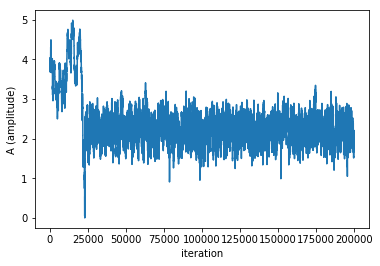

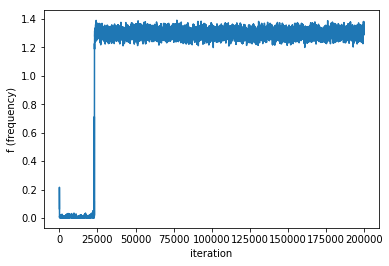

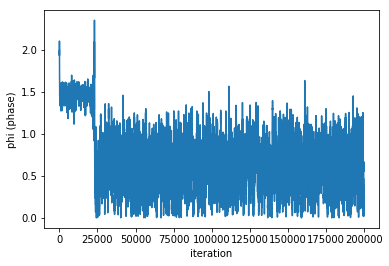

In [30]:
plt.plot(samples[:,0])
plt.xlabel('iteration')
plt.ylabel('A (amplitude)')
plt.show()

plt.plot(samples[:,1])
plt.xlabel('iteration')
plt.ylabel('f (frequency)')
plt.show()

plt.plot(samples[:,2])
plt.xlabel('iteration')
plt.ylabel('phi (phase)')
plt.show()

Use the above plots to determine how many samples to throw out as "burn-in" (i.e. before the chain settles to a steady state)

In [31]:
#After abour 25000 samples, the chains seem to have settled
burnin = 25000
samples = samples[burnin:]

Plot the samples for different parameters. This will reveal possible degeneracies and correlations between the parameters. Are any parameters correlated?

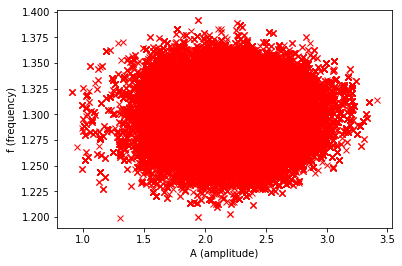

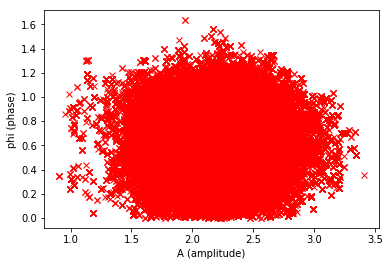

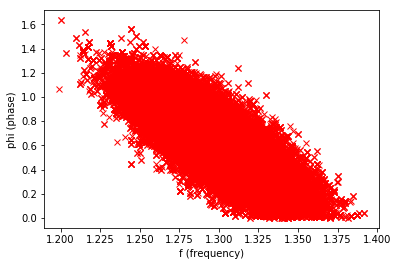

In [32]:
plt.plot(samples[:,0],samples[:,1],'x',color='red')
plt.xlabel('A (amplitude)')
plt.ylabel('f (frequency)')
plt.show()

plt.plot(samples[:,0],samples[:,2],'x',color='red')
plt.xlabel('A (amplitude)')
plt.ylabel('phi (phase)')
plt.show()

plt.plot(samples[:,1],samples[:,2],'x',color='red')
plt.xlabel('f (frequency)')
plt.ylabel('phi (phase)')
plt.show()


But not all samples are independent. Calculate the auto-correlation of the remaining samples

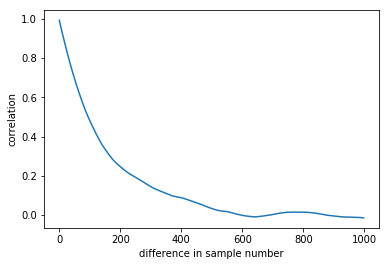

In [33]:
xmean=(np.mean(samples[:,0]))
xvar=(np.var(samples[:,0]))
ACL=np.array([(((samples[h:,0]-xmean)*(samples[:-h,0]-xmean)).sum())/(len(samples[:,0])-h)/xvar for h in range(1,1000)])                              

plt.plot(ACL)
plt.xlabel(r'difference in sample number')
plt.ylabel(r'correlation')
plt.show()

Use the plot to determine the correlation length between samples and 'thin' the chains

In [34]:
corrlength = 400 #where the correlation drops to about 0.1
independentsamples = samples[::corrlength]
print independentsamples.shape
print 'effective acceptance ratio:', 1.*independentsamples.shape[0]/Nsteps

(438, 3)
effective acceptance ratio: 0.00219


Plot the samples for different parameters again, now using only *independent* samples

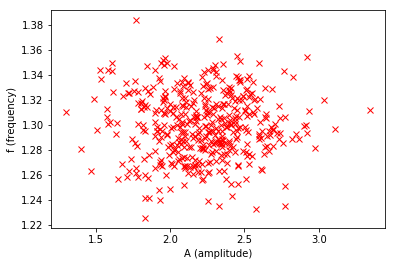

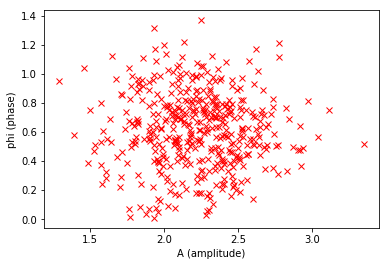

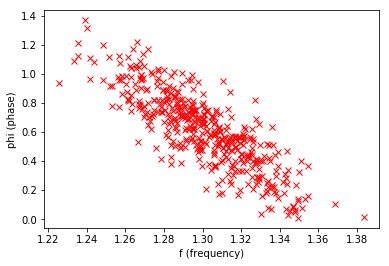

In [35]:
plt.plot(independentsamples[:,0],independentsamples[:,1],'x',color='red')
plt.xlabel('A (amplitude)')
plt.ylabel('f (frequency)')
plt.show()

plt.plot(independentsamples[:,0],independentsamples[:,2],'x',color='red')
plt.xlabel('A (amplitude)')
plt.ylabel('phi (phase)')
plt.show()

plt.plot(independentsamples[:,1],independentsamples[:,2],'x',color='red')
plt.xlabel('f (frequency)')
plt.ylabel('phi (phase)')
plt.show()


The one dimensional posterior for each parameter is obtain by marginalizing over all other parameters. In practise, the marginalized posterior is the normalized histogram of the samples

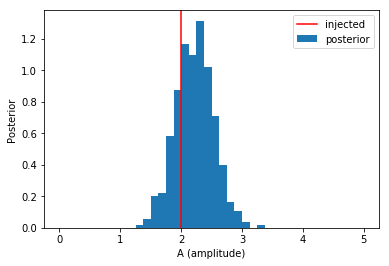

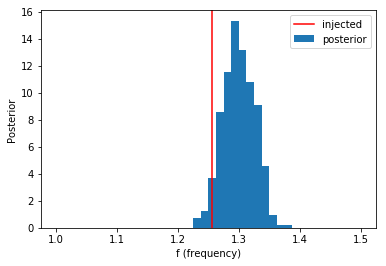

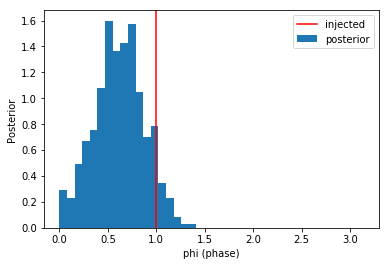

In [36]:
x_values = independentsamples[:,0]

plt.hist(x_values,range=(0,5),bins=40,normed=True,label='posterior')
plt.axvline(A,color='r',label='injected')
plt.xlabel('A (amplitude)')
plt.ylabel('Posterior')
plt.legend()
plt.show()

y_values = independentsamples[:,1]

plt.hist(y_values,range=(1,1.5),bins=40,normed=True,label='posterior')
plt.axvline(f,color='r',label='injected')
plt.xlabel('f (frequency)')
plt.ylabel('Posterior')
plt.legend()
plt.show()

z_values = independentsamples[:,2]

plt.hist(z_values,range=(0,np.pi),bins=40,normed=True,label='posterior')
plt.axvline(phi,color='r',label='injected')
plt.xlabel('phi (phase)')
plt.ylabel('Posterior')
plt.legend()
plt.show()

The posterior distribution falls close to the 'true' value of each parameter but doesn't peak exactly at it. **Try removing the noise realization from the data and rerunning the chain.**

**Compute the mean, median and 90% credible intervals for the 3 signal parameters**

**Compute the expectation value of $A^2$ (the amplitude of the signal squared). Hint: $<A^2> = \int A^2 p(A|d) dA$**

Let's plot the data and our 90% posterior credible interval for them (similar to Fig. 4 [here](https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.118.221101))

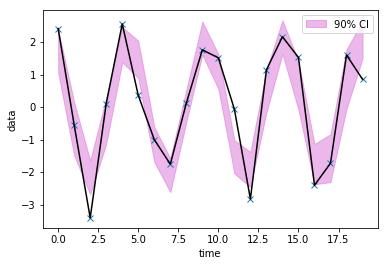

In [37]:
percentile5=np.zeros(len(t))
percentile95=np.zeros(len(t))
for time in t:
    d=model(independentsamples[:,0],independentsamples[:,1],independentsamples[:,2],time)
    percentile5[time] = np.percentile(d,5)
    percentile95[time] = np.percentile(d,95)

fig, ax = plt.subplots()    
ax.fill_between(t, percentile5, percentile95, color='orchid',alpha=0.5, label="90% CI")
plt.plot(data,'x')
plt.plot(data,'k')
plt.xlabel('time')
plt.ylabel('data')
plt.legend()
plt.show()

The 90% credible interval doesn't include all the data points. **Is that ok?**

In practice: Run several chains with different starting values and make sure that they all converge to the same area. **Change the random seed and run the chain again**

**Change the parameter priors and run the chain again**

Various python modules exist that have some of these methods pre-implemented, e.g.: [emcee](http://dan.iel.fm/emcee/current/), [kombine](http://pages.uoregon.edu/bfarr/kombine/)
    